# Module 4.3 - LSTM
Link to original paper: http://www.bioinf.jku.at/publications/older/2604.pdf

Link to dataset generation: http://christianherta.de/lehre/dataScience/machineLearning/neuralNetworks/reberGrammar.php

## Lessons Learned
The model in this project is a little different from all the other projects' models. In those projects, full vectorization can be achieve since there is alway full connectivity. In this project, full vectorization can be achieved too (which is what I did), but due to some sparse connectivities (the ones connect the gates with memory cells) and recurrent connectivities, it is a lot harder to implement and can be prone to bugs. 

One more note on the implementation of neural networks: deciding on where to store the previous activations and inputs should be a careful decision to make. I decided to put them in the lowest abstraction level possible, but it was not a good idea. Instead, I should have to put them "as low in the abstraction level as possible". The distinction between lowest level and as low as possible is the following: lowest level means to store activations and inputs in Sigmoid classes, Linear classes, and Softmax classes, hoping to simplify the forward/backward propgation steps; on the other hand, if you store those data as low as possible, you are storing those which have recurrent connections (e.g. gates) and those without (e.g. output) differently. 

In addtion to lessons I learned while implementing the LSTM, I learn some facts about this model (the one I implemented that is, which could be prone to bugs). Firstly, the model converges on greedy outputs. By greedy outputs, I mean the outputs that make statistical sense, but don't make temporal sense. In terms of statistics, it makes sense that the model abuses the frequency of the output neuron activates: the more a neuron activates, the more likely it is going to activate. However, in the Embedded Reber Grammar problem, statistics of a neuron's activation isn't everything. The model must sccount for the temporal dependency. It must look at the past time steps, which is the point of inventing LSTM in the first place. Secondly, neither Nadam nor SGD were able to converge toward using temporal dependency of the data. Oh, and in fact, SGD performed very simliar to Nadam if not slightly more stable.

## Introduction
LSTM was invented to solve the problem of vanishing gradients. Vanishing gradients is a problem occurs in RNNs, where the errors of RNN's weights exponentially decay as the RNN unfolds in time. As LSTM unfolds in time, however, the error stays constant. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt  # Plotting library
# Allow matplotlib to plot inside this notebook
%matplotlib inline
from tqdm import tqdm

/Users/macbook/miniconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1120: UserWarning: Bad val "$TEMPLATE_BACKEND" on line #41
	"backend      : $TEMPLATE_BACKEND
"
	in file "/Users/macbook/.matplotlib/matplotlibrc"
	Key backend: Unrecognized backend string "$template_backend": valid strings are [u'pgf', u'ps', u'Qt4Agg', u'GTK', u'GTKAgg', u'nbAgg', u'agg', u'cairo', u'MacOSX', u'GTKCairo', u'Qt5Agg', u'template', u'WXAgg', u'TkAgg', u'GTK3Cairo', u'GTK3Agg', u'svg', u'WebAgg', u'pdf', u'gdk', u'WX']
  (val, error_details, msg))


## Dataset
The dataset in this module is the embedded reber grammar problem.

A sequence of chars will be generated based on the following graph, where each path is chosen at random. 

Each char is encoded as one hot vector. 

### The Embedded Reber Grammar

![Embedded Reber Grammar](http://christianherta.de/lehre/dataScience/machineLearning/neuralNetworks/pics/embeddedReberGrammar.png)

In [2]:
chars = "BTSXPVE "

graph = [[(1,5),('T','P')] , [(1,2),('S','X')], \
           [(3,5),('S','X')], [(6,),('E',)], \
           [(3,2),('V','P')], [(4,5),('V','T')], \
           [(6,6),(' ',' ')] ]

def in_grammar(word):
    if word[0] != 'B':
        return False
    node = 0    
    for c in word[1:]:
        transitions = graph[node]
        try:
            node = transitions[0][transitions[1].index(c)]
        except ValueError: # using exceptions for flow control in python is common
            return False
    return True 

def generate_sequences(nb_samples, length):
    assert nb_samples > 0
    
    in_sequences = []
    out_sequences = []
    
    for i in range(nb_samples):
        node = 0
        in_sequences.append("B")
        out_sequences.append("")
        for _ in range(length):
            transition = graph[node]
            # randomly get a connection
            j = np.random.randint(0,len(transition[0]))
            # generate char sequence
            in_sequences[i] += transition[1][j]
            out_sequences[i] += transition[1][j]
            node = transition[0][j]
        assert in_grammar(in_sequences[i])
    
    assert len(in_sequences) == nb_samples
    assert len(out_sequences) == nb_samples
    
    return in_sequences, out_sequences

def char_to_one_hot(c):
    assert chars.index(c) != -1
    
    one_hot = np.zeros(len(chars))
    one_hot[chars.index(c)] = 1
    
    return list(one_hot)

def one_hot_to_char(one_hot):
    assert len(one_hot) == len(chars)
    # must have one "1" encoded
    assert one_hot.count(1) == 1
    assert one_hot.count(0) == len(chars) - 1
    assert one_hot.index(1) != -1
    
    return chars[one_hot.index(1)]
    
    
def sequences_to_one_hots(sequences):
    assert len(sequences) > 0
    
    one_hots = []
    for s in sequences:
        one_hots.append([])
        for c in s:
            one_hot = char_to_one_hot(c)
            assert c == one_hot_to_char(one_hot)
            one_hots[-1].append(one_hot)
        assert len(one_hots[-1]) == len(s)
        
    assert len(sequences) == len(one_hots)
    return one_hots

def one_hots_to_sequences(one_hots):
    assert len(one_hots) > 0
    
    sequences = []
    for sample in one_hots:
        sequences.append("")
        for one_hot in sample:
            sequences[-1] += one_hot_to_char(one_hot)
            assert char_to_one_hot(sequences[-1][-1]) == one_hot
        assert len(sample) == len(sequences[-1])
    
    assert len(one_hots) == len(sequences)
    return sequences

def checkSymmetry(embedded = False):
    if not embedded:
        sequences, _ = generate_sequences(20, 20)
    else:
        sequences, _ = generate_embedded_sequence(20, 20)
    one_hots = sequences_to_one_hots(sequences)
    assert sequences == one_hots_to_sequences(one_hots)

def generate_embedded_sequence(nb_samples, length):
    in_sequences, out_sequences = generate_sequences(nb_samples, length)
    for i in range(nb_samples):
        embed = generate_sequences(1, length)[0][0].rstrip()
        assert in_grammar(in_sequences[i])
        in_sequences[i] = in_sequences[i][:2] + embed + in_sequences[i][2:]
        in_sequences[i] = in_sequences[i][:length]
        out_sequences[i] = out_sequences[i][:1] + embed + out_sequences[i][1:]
        out_sequences[i] = out_sequences[i][:length - 1]
        assert "B" + out_sequences[i] == in_sequences[i]
        out_sequences[i] += " "
    assert len(in_sequences) == nb_samples
    return in_sequences, out_sequences

checkSymmetry(True)

In [3]:
X_train, t_train = generate_embedded_sequence(256, 20)
X_test, t_test = generate_embedded_sequence(256, 20)

X_train = sequences_to_one_hots(X_train)
t_train = sequences_to_one_hots(t_train)
X_test = sequences_to_one_hots(X_test)
t_test = sequences_to_one_hots(t_test)

## Long Short Term Memory
Layers and gates

In [4]:
learning_rate = 0.15
momentum = 0.1
itr = 1000

In [5]:
# split matrix top down (by columns)
class MatrixSplitter(object):
    def __init__(self, col_per_out):
        assert isinstance(col_per_out, list)
        assert len(col_per_out) > 1
        
        self.cols = [0]
        col_per_out = col_per_out
        for i in range(1, len(col_per_out)):
            self.cols.append(self.cols[-1] + col_per_out[i - 1])
        self.cols.remove(0)
        
    def forward(self, X):
        return np.split(X, self.cols, axis = -1)
    
    def backward(self, Y):
        return np.concatenate(Y, axis = -1)
        

In [6]:
class Sigmoid(object):
    def __init__(self):
        self.activation = []
    def forward(self, X):
        self.activation.append(1 / (1 + np.exp(-X)))
        return self.activation[-1]
    def backward(self, outgrad):
        activations = np.reshape(np.ravel(self.activation), (np.array(self.activation).shape[2],np.array(self.activation).shape[0] * np.array(self.activation).shape[1])).T
        out = outgrad * activations * (1 - activations)
        self.activation = []
        return out

In [7]:
class Softmax(object):
    def forward(self, z):
        self.activation = (np.exp(z) / np.sum(np.exp(z), axis=-1, keepdims=True))
        return self.activation
    def backward(self, outgrad):
        out = (self.activation - outgrad) / self.activation.shape[0]
        return out
    def cost(self, T):
        return - np.multiply(T, np.log(self.activation)).sum() / self.activation.shape[0]

In [8]:
# Nadam hyperparameters
t = 0
beta_1 = 0.9
beta_2 = 0.999
eps = 1e-8

In [9]:
class Linear(object):
    def __init__(self, W, b = None):
        self.W = W
        if b == None:
            self.b = 0
        else:
            self.b = b
        self.X = []
        
        # for Nadam
        self.param_grad = 0
        self.b_grad = 0
        self.param_v_t = 0
        self.param_m_t = 0
        self.b_m_t = 0
        self.b_v_t = 0
        
        # SGD
        self.param_update = 0
        self.b_update = 0
        
    def forward(self, X):
        self.X.append(X)
        return np.tensordot(X, self.W, axes=((-1), (0))) + self.b
    
    def backward(self, outgrad):
        # calculate return value before we change weights
        grad = np.tensordot(outgrad, self.W.T, axes=((-1), (0)))
        # calculate weight changes
        bpaxes = tuple(range(len(outgrad.shape) - 1))
        if len(np.array(self.X).shape) == 4:
            self.X = self.X[0]
        if len(np.array(self.X).shape) - len(outgrad.shape) == 1:
            self.X = np.reshape(self.X, (np.array(self.X).shape[0] * np.array(self.X).shape[1], np.array(self.X).shape[2]))
        #print np.array(self.X).shape, outgrad.shape, bpaxes
        param_grad = np.tensordot(np.array(self.X), outgrad, axes=(bpaxes, bpaxes))
        b_grad = np.sum(outgrad, axis = bpaxes)
        self.update_weights(param_grad, b_grad)
        self.X = []
        return grad
    '''
    #Nadam
    def update_weights(self, param_grad, b_grad):
        global learning_rate
        global momentum
        global t
        
        t += 1
        
        # update weights
        self.param_m_t = beta_1 * self.param_m_t + (1 - beta_1) * self.param_grad
        self.param_v_t = beta_2 * self.param_v_t + (1 - beta_2) * self.param_grad ** 2
        g_corr_t = self.param_grad / (1 - beta_1 ** t)
        m_corr_t = self.param_m_t / (1 - beta_1 ** (t + 1))
        v_corr_t = self.param_v_t / (1 - beta_2 ** t)
        m_nes_t = (1 - beta_1) * g_corr_t + beta_1 * m_corr_t
        
        self.W = self.W - learning_rate * m_nes_t / ((v_corr_t ** 0.5) + eps)
        
        # update bias
        self.b_m_t = beta_1 * self.b_m_t + (1 - beta_1) * self.b_grad
        self.b_v_t = beta_2 * self.b_v_t + (1 - beta_2) * self.b_grad ** 2
        g_corr_t = self.b_grad / (1 - beta_1 ** t)
        m_corr_t = self.b_m_t / (1 - beta_1 ** (t + 1))
        v_corr_t = self.b_v_t / (1 - beta_2 ** t)
        m_nes_t = (1 - beta_1) * g_corr_t + beta_1 * m_corr_t
        
        self.b = self.b - learning_rate * m_nes_t / ((v_corr_t ** 0.5) + eps)
        
        # save for later
        self.param_grad = param_grad
        self.b_grad = b_grad
    '''
    #stochastic gradient descent with momentum
    def update_weights(self, param_grad, b_grad):
        global learning_rate
        global momentum
        
        param_momentum = self.param_update * momentum
        b_momentum = self.b_update * momentum
        
        self.param_update = - param_grad * learning_rate + param_momentum
        self.b_update = - b_grad * learning_rate + b_momentum
        
        #print "grad: " + repr(param_grad.shape), "w: " + repr(self.W.shape)
        self.W += self.param_update 
        self.b += self.b_update 

## Update Parameters - Nadam
The following section contains the implementation of the gradient based optimization technique

Pusedo-code: 
```python
notations: 
    learning_rate
    eps: fudge factor
    beta_1, beta_2: decay rates
    f(theta): objective function
    g(theta): gradient function of f
    theta_0: initial param
    m_0 = 0: first moment
    v_0 = 0: second raw moment
    t_0 = 0: initial time step
algorithm:
    while not CONVERGE:
        t += 1
        g_t = g(theta_t-1)
        m_t = beta_1 * m_t-1 + (1 - beta_1) * g_t
        v_t = beta_2 * v_t-1 + (1 - beta_2) * g_t ** 2
        g_corr_t = g_t / (1 - beta_1 ** t)
        m_corr_t = m_t / (1 - beta_1 ** (t + 1))
        v_corr_t = v_t / (1 - beta_2 ** t)
        m_nes_t = (1 - beta_1) * g_corr_t + beta_1 * m_corr_t
        theta_t = theta_t-1 - learning_rate * m_nes_t / (sqrt(v_corr_t) + eps)
```

In [10]:
class Gate(object):
    def __init__(self, W, b = None):
        self.linear = Linear(W, b)
        self.sigmoid = Sigmoid()
    def forward(self, X):
        return self.sigmoid.forward(self.linear.forward(X))
    def backward(self, outgrad):
        return self.linear.backward(self.sigmoid.backward(outgrad))

In [11]:
class MemoryBlock(object):
    def __init__(self, W_i, W_r, b, nb_of_memory_cells_per_block):
        self.nb_of_inputs = W_i.shape[0]
        self.nb_of_units = W_r.shape[1]
        nb_of_memory_blocks = self.nb_of_units / (nb_of_memory_cells_per_block + 2)
        nb_of_in_out_gates = nb_of_memory_blocks
        self.nb_of_memory_cell_gates = nb_of_memory_blocks * nb_of_memory_cells_per_block
        self.nb_of_memory_cells_per_block = nb_of_memory_cells_per_block
        self.nb_of_gates = nb_of_in_out_gates * 2
        
        # let's call the g unit along with its incoming connections a "memory cell gate"
        self.memory_cell_gate = Gate(np.concatenate([W_i[:, :self.nb_of_memory_cell_gates], W_r[:, :self.nb_of_memory_cell_gates]], axis = 0))
        self.input_gate = Gate(np.concatenate([W_i[:, self.nb_of_memory_cell_gates:self.nb_of_memory_cell_gates+nb_of_in_out_gates], W_r[:, self.nb_of_memory_cell_gates:self.nb_of_memory_cell_gates+nb_of_in_out_gates]]), b[:, 0])
        self.output_gate = Gate(np.concatenate([W_i[:, self.nb_of_memory_cell_gates+nb_of_in_out_gates:], W_r[:, self.nb_of_memory_cell_gates+nb_of_in_out_gates:]]), b[:, 1])
        self.non_linearity = Sigmoid()
        
    def unfold(self, X):
        self.h = []
        self.g = []
        self.y_in_his = []
        self.y_out_his = []
        
        X_r = np.zeros((X.shape[0], self.nb_of_units))
        S = np.zeros((X.shape[0], self.nb_of_memory_cell_gates))
        output = np.zeros((X.shape[0], X.shape[1], self.nb_of_memory_cell_gates))
                          
        for k in range(X.shape[1]):
            X_k = np.concatenate([X_r, X[:, k, :]], axis = -1)
            self.g.append(self.memory_cell_gate.forward(X_k))
            y_in = self.input_gate.forward(X_k)
            y_out = self.output_gate.forward(X_k)
            # update X_r partially
            X_r[:, :self.nb_of_gates] = np.concatenate([y_in, y_out], axis = -1)
            self.y_in_his.append(np.repeat(y_in, 2, axis = -1))
            self.y_out_his.append(np.repeat(y_out, 2, axis = -1))
            g_y_in = np.multiply(self.g[-1], self.y_in_his[-1])
            S += g_y_in
            self.h.append(self.non_linearity.forward(S))
            h_y_out = np.multiply(self.h[-1], self.y_out_his[-1])
            X_r[:,self.nb_of_gates:] =  h_y_out
            output[:, k, :] = h_y_out
            
        self.h = np.array(self.h)
        self.g = np.array(self.g)
        self.y_in_his = np.array(self.y_in_his)
        self.y_out_his = np.array(self.y_out_his)
        
        self.h = np.reshape(np.ravel(self.h.T), (self.h.shape[2],self.h.shape[0] * self.h.shape[1])).T
        self.g = np.reshape(np.ravel(self.g.T), (self.g.shape[2],self.g.shape[0] * self.g.shape[1])).T
        self.y_in_his = np.reshape(np.ravel(self.y_in_his.T), (self.y_in_his.shape[2],self.y_in_his.shape[0] * self.y_in_his.shape[1])).T
        self.y_out_his = np.reshape(np.ravel(self.y_out_his.T), (self.y_out_his.shape[2],self.y_out_his.shape[0] * self.y_out_his.shape[1])).T
        
        return output
    
    def bptt(self, outgrad):
        nb_of_time_steps = outgrad.shape[1]
        nb_of_samples = outgrad.shape[0]
        
        outgrad = np.reshape(np.ravel(outgrad), (outgrad.shape[0] * outgrad.shape[1], outgrad.shape[2]))
        g_y_out = np.multiply(self.h, outgrad)
        g_h = np.multiply(self.h, self.y_out_his)
        g_S = self.non_linearity.backward(g_h)
        g_g_y_in = np.multiply(self.g, g_S)
        g_g = np.multiply(self.g, self.y_in_his)
        
        # put everything back to shape
        g_g_from_memory_cells = self.memory_cell_gate.backward(g_g)[:, :self.nb_of_inputs]
        g_g_from_memory_cells = np.reshape(np.ravel(g_g_from_memory_cells), (nb_of_samples, nb_of_time_steps, g_g_from_memory_cells.shape[1]))
        
        #g_g_y_in = np.reshape(np.ravel(g_g), (nb_of_samples, nb_of_time_steps, g_g_y_in.shape[1]))
        g_g_y_in = np.sum(np.reshape(np.ravel(g_g_y_in), (g_g_y_in.shape[0], g_g_y_in.shape[1] / 2, 2) ), axis = -1)
        # only propgate the input errors
        # because the errors from networks are not suppose to go back in time
        g_g_from_input_gates = self.input_gate.backward(g_g_y_in)[:, :self.nb_of_inputs]
        g_g_from_input_gates = np.reshape(np.ravel(g_g_from_input_gates), (nb_of_samples, nb_of_time_steps, g_g_from_input_gates.shape[1]))

        #g_y_out = np.reshape(np.ravel(g_g), (nb_of_samples, nb_of_time_steps, g_y_out.shape[1]))
        g_y_out = np.sum(np.reshape(np.ravel(g_y_out), (g_y_out.shape[0], g_y_out.shape[1] / 2, 2) ), axis = -1)
        g_g_from_output_gates = self.output_gate.backward(g_y_out)[:, :self.nb_of_inputs]
        g_g_from_output_gates = np.reshape(np.ravel(g_g_from_output_gates), (nb_of_samples, nb_of_time_steps, g_g_from_output_gates.shape[1]))
        
        return g_g_from_memory_cells + g_g_from_input_gates + g_g_from_output_gates
        

## Model

In [26]:
class LSTM(object):
    def __init__(self, n_in, n_out, nb_of_memory_blocks, nb_of_memory_cells_per_block):
        
        # input layer
        n_hidden = nb_of_memory_blocks * nb_of_memory_cells_per_block
        self.input = Linear(np.random.uniform(-1, 1, (n_in, n_in)))
        
        # connectivity
        W_i = np.random.uniform(-1, 1, (n_in, n_hidden + 2 * nb_of_memory_blocks))
        W_r = np.random.uniform(-1, 1, (n_hidden + 2 * nb_of_memory_blocks, n_hidden + 2 * nb_of_memory_blocks))
        b = np.random.uniform(-1, 1, (nb_of_memory_blocks, 2))
        
        # hidden layer
        self.hidden = MemoryBlock(W_i, W_r, b, nb_of_memory_cells_per_block)
        
        # output layer
        self.output_linear = Linear(np.random.uniform(-1, 1, (n_hidden, n_out)))
        self.output_non_linearity = Softmax()
        
        self.historical_costs = []
        
    def forward(self, X):
        #z_input = self.input.forward(X)
        z_input = np.array(X)
        z_hidden = self.hidden.unfold(z_input)
        z_output_linear =  self.output_linear.forward(z_hidden)
        return self.output_non_linearity.forward(z_output_linear)
    
    def backward(self, T):
        outgrad = self.output_non_linearity.backward(T)
        outgrad = self.output_linear.backward(outgrad)
        outgrad = self.hidden.bptt(outgrad)
        #outgrad = self.input.backward(outgrad)
        self.historical_costs.append(self.output_non_linearity.cost(T))
        return outgrad

In [55]:
lstm = LSTM(8, 8, 3, 2)

/Users/macbook/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  after removing the cwd from sys.path.


In [56]:
for _ in tqdm(range(itr)):
    X_train, t_train = generate_embedded_sequence(256, 20)

    X_train = sequences_to_one_hots(X_train)
    t_train = sequences_to_one_hots(t_train)

    lstm.forward(X_train)
    lstm.backward(t_train)

100%|██████████| 1000/1000 [03:46<00:00,  4.33it/s]


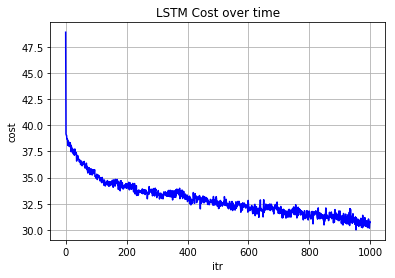

In [82]:
plt.plot(lstm.historical_costs, 'b-')
plt.xlabel('itr')
plt.ylabel('cost')
plt.title('LSTM Cost over time')
plt.grid()
plt.show()

In [98]:
X_test, t_test = generate_embedded_sequence(1, 1)
X_test = sequences_to_one_hots(X_test)
t_test = sequences_to_one_hots(t_test)

idx = np.argmax(lstm.forward(X_test), axis = 2)[0]
out = []
for i in idx:
    out.append([0,0,0,0,0,0,0,0])
    out[-1][i] = 1
print one_hots_to_sequences([out])
print one_hots_to_sequences(t_test)

[[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]]
['T']
[' ']


In [74]:
generate_embedded_sequence(1, 10)[0]

['BTBTSXXVPX']

In [75]:
print lstm.historical_costs[len(lstm.historical_costs)-10:]

[30.319092434522659, 30.221080922352868, 30.643779199659278, 30.686330581806828, 31.045844879419608, 30.427760527818808, 30.212239454344918, 30.16245575380033, 30.819688839932223, 30.712528673221264]


In [76]:
print np.round(np.sum(lstm.output_linear.W, axis = 1))

[ 0. -2. -0. -1. -0. -3.]


In [77]:
print np.round(np.sum(lstm.hidden.output_gate.linear.W, axis = 1))

[ 1. -0.  1. -1. -1. -2. -2. -0. -0. -1. -1.  1.  1. -0. -1. -1.  0. -2.
 -0.  0.]


In [78]:
print np.round(np.sum(lstm.hidden.input_gate.linear.W, axis = 1))

[ -5. -16. -12. -14.  -8.  -9.  -9.  -7.  -6.  -7.  -7.  -7.  -4.  -3.  -1.
  -2.  -2.  -3.  -2.  -5.]


In [79]:
print np.round(np.sum(lstm.hidden.memory_cell_gate.linear.W, axis = 1))

[ -52. -254. -217. -213. -128. -120. -148. -146. -115. -113. -108. -107.
  -35.  -44.  -34.  -33.  -31.  -48.  -33.  -92.]


In [119]:
idx = np.argmax(lstm.forward([[[0,0,0,0,0,1,0,0]]]), axis = 2)

In [120]:
idx[0][0]

7